In [ ]:
%cd /content/ComfyUI

import os, json, requests, random, time
from urllib.parse import urlsplit

import torch
from PIL import Image
import numpy as np

from nodes import load_custom_node
from nodes import NODE_CLASS_MAPPINGS

load_custom_node("/content/ComfyUI/custom_nodes/ComfyUI_InstantIR_Wrapper")

LoadImage = NODE_CLASS_MAPPINGS["LoadImage"]()
InstantIR_Loader = NODE_CLASS_MAPPINGS["InstantIR_Loader"]()
InstantIR_Sampler = NODE_CLASS_MAPPINGS["InstantIR_Sampler"]()

with torch.inference_mode():
    model = InstantIR_Loader.main_("dreamshaperXL_lightningDPMSDE.safetensors",
                                    "/content/ComfyUI/models/dinov2",
                                    "models/adapter.pt",
                                    "models/aggregator.pt",
                                    "sdxl/lcm/pytorch_lora_weights.safetensors",
                                    "models/previewer_lora_weights.bin", True, False)[0]

def download_file(url, save_dir, file_name):
    os.makedirs(save_dir, exist_ok=True)
    file_suffix = os.path.splitext(urlsplit(url).path)[1]
    file_name_with_suffix = file_name + file_suffix
    file_path = os.path.join(save_dir, file_name_with_suffix)
    response = requests.get(url)
    response.raise_for_status()
    with open(file_path, 'wb') as file:
        file.write(response.content)
    return file_path

@torch.inference_mode()
def generate(input):
    values = input["input"]

    input_image=values['input_image_check']
    input_image=download_file(url=input_image, save_dir='/content/ComfyUI/input', file_name='input_image')
    prompt = values['prompt']
    negative_prompt = values['negative_prompt']
    seed = values['seed']
    steps = values['steps']
    cfg = values['cfg']
    creative_restoration = values['creative_restoration']
    width = values['width']
    height = values['height']
    preview_start = values['preview_start']
    guidance_end = values['guidance_end']
    batch_size = values['batch_size']

    pixels, _ = LoadImage.load_image(input_image)

    if seed == 0:
        random.seed(int(time.time()))
        seed = random.randint(0, 18446744073709551615)

    image = InstantIR_Sampler.main(model, pixels, prompt, negative_prompt, seed, steps, cfg, creative_restoration, width, height, preview_start, guidance_end, batch_size)[0]
    return Image.fromarray(np.array(image*255, dtype=np.uint8)[0])

The config attributes {'interpolation_type': 'linear', 'skip_prk_steps': True, 'use_karras_sigmas': False} were passed to LCMSingleStepScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


init latent at 876


  0%|          | 0/8 [00:00<?, ?it/s]

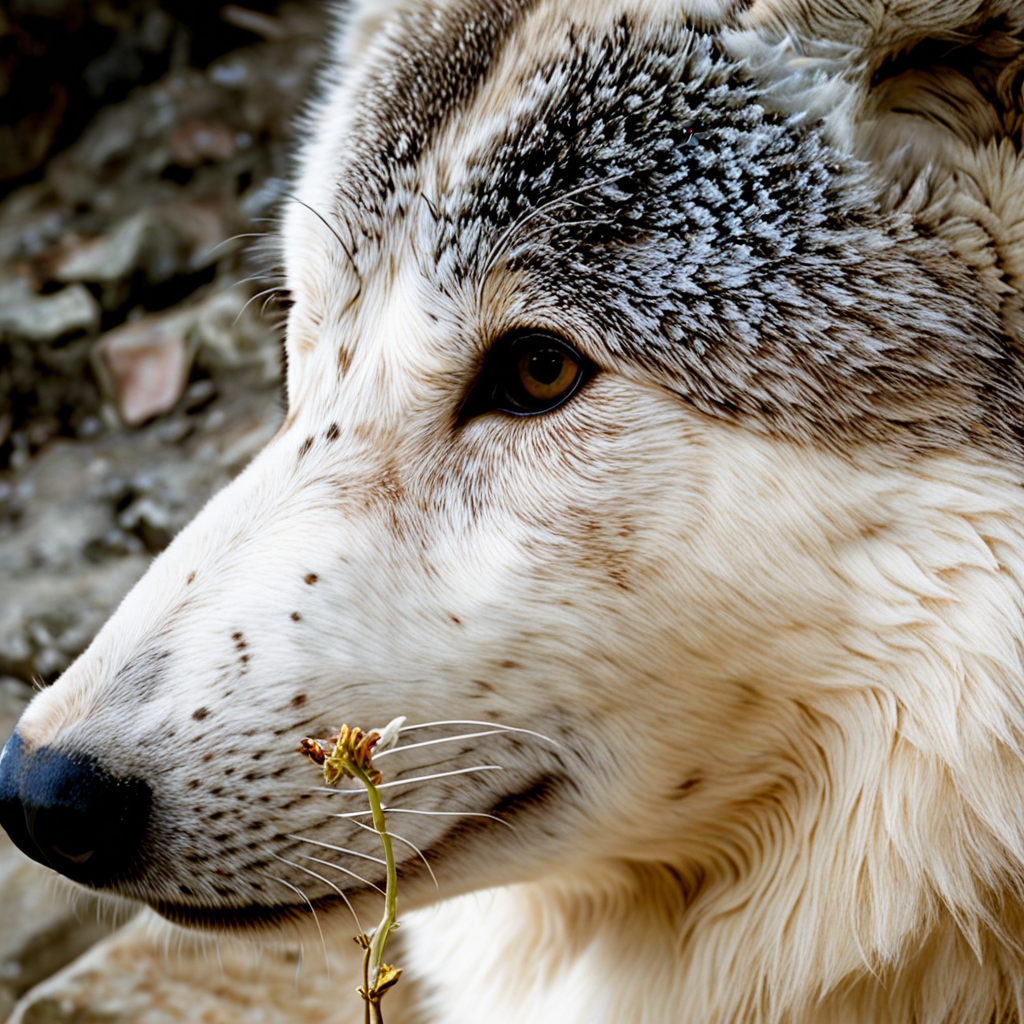

In [3]:
input = { 
    "input": {
        "input_image_check": "https://files.catbox.moe/39ttgr.png",
        "prompt": "Photorealistic, highly detailed, hyper detailed photo - realistic maximum detail, 32k, ultra HD, extreme meticulous detailing, skin pore detailing, hyper sharpness, perfect without deformations, taken using a Canon EOS R camera, Cinematic, High Contrast, Color Grading.",
        "negative_prompt": "blurry, out of focus, unclear, depth of field, over-smooth, sketch, oil painting, cartoon, CG Style, 3D render, unreal engine, dirty, messy, worst quality, low quality, frames, painting, illustration, drawing, art, watermark, signature, jpeg artifacts, deformed, lowres",
        "seed": 0,
        "steps": 8,
        "cfg": 4.0,
        "creative_restoration": False,
        "width": 1024,
        "height": 1024,
        "preview_start": 0.0,
        "guidance_end": 1.0,
        "batch_size": 1
    }
}
image = generate(input)
image